# Bitcoin and Ethereum price prediction with LSTM


In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
%matplotlib inline

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Setting up hyper parameters and global variables for our model:

In [3]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 2  #10                  
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

Here we will define functions for preprocessing our data as well as the build_model function:

In [4]:
def get_market_data(market, tag=True):
  
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  market_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']  
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data

def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  data = data[['Date']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

Below are the functions for plotting market data and the results after the training:

In [5]:
def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

Load the market data into variables *btc_data* and *eth_data*:

In [6]:
btc_data = get_market_data("bitcoin", tag='BTC')
eth_data = get_market_data("ethereum", tag='ETH')

In [7]:
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2019-09-06,10578.20,10898.76,10292.30,10353.30,1.953657e+10,185530405363
1,2019-09-05,10588.18,10627.27,10516.42,10575.53,1.455124e+10,189492405383
2,2019-09-04,10621.18,10762.64,10434.71,10594.49,1.674266e+10,189810010608
3,2019-09-03,10345.73,10736.10,10308.55,10623.54,1.938492e+10,190312487956
4,2019-09-02,9757.47,10396.59,9730.65,10346.76,1.724810e+10,185333114163


Merging the BTC and ETH data and splitting them to training and test sets:

In [8]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [9]:
model_data.head()

,Date,BTC_Close,BTC_Volume,ETH_Close,ETH_Volume
1344,2016-01-01,434.33,36278900.0,0.948024,206062
1343,2016-01-02,433.44,30096600.0,0.937124,255504
1342,2016-01-03,430.01,39633800.0,0.971905,407632
1341,2016-01-04,433.09,38477500.0,0.954480,346245
1340,2016-01-05,431.96,34522600.0,0.950176,219833


Pre-processing data and producing inputs and target outputs:

In [10]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(1069, 7, 4) (262, 7, 4) (1069,) (262,)
(1069, 7, 4) (262, 7, 4) (1069,) (262,)


In [11]:
train_set.head(2)

,BTC_Close,BTC_Volume,ETH_Close,ETH_Volume
1344,434.33,36278900.0,0.948024,206062
1343,433.44,30096600.0,0.937124,255504


Initializing the model and training it for predicting BTC price for next day:

In [12]:
# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)  

Plot the results:

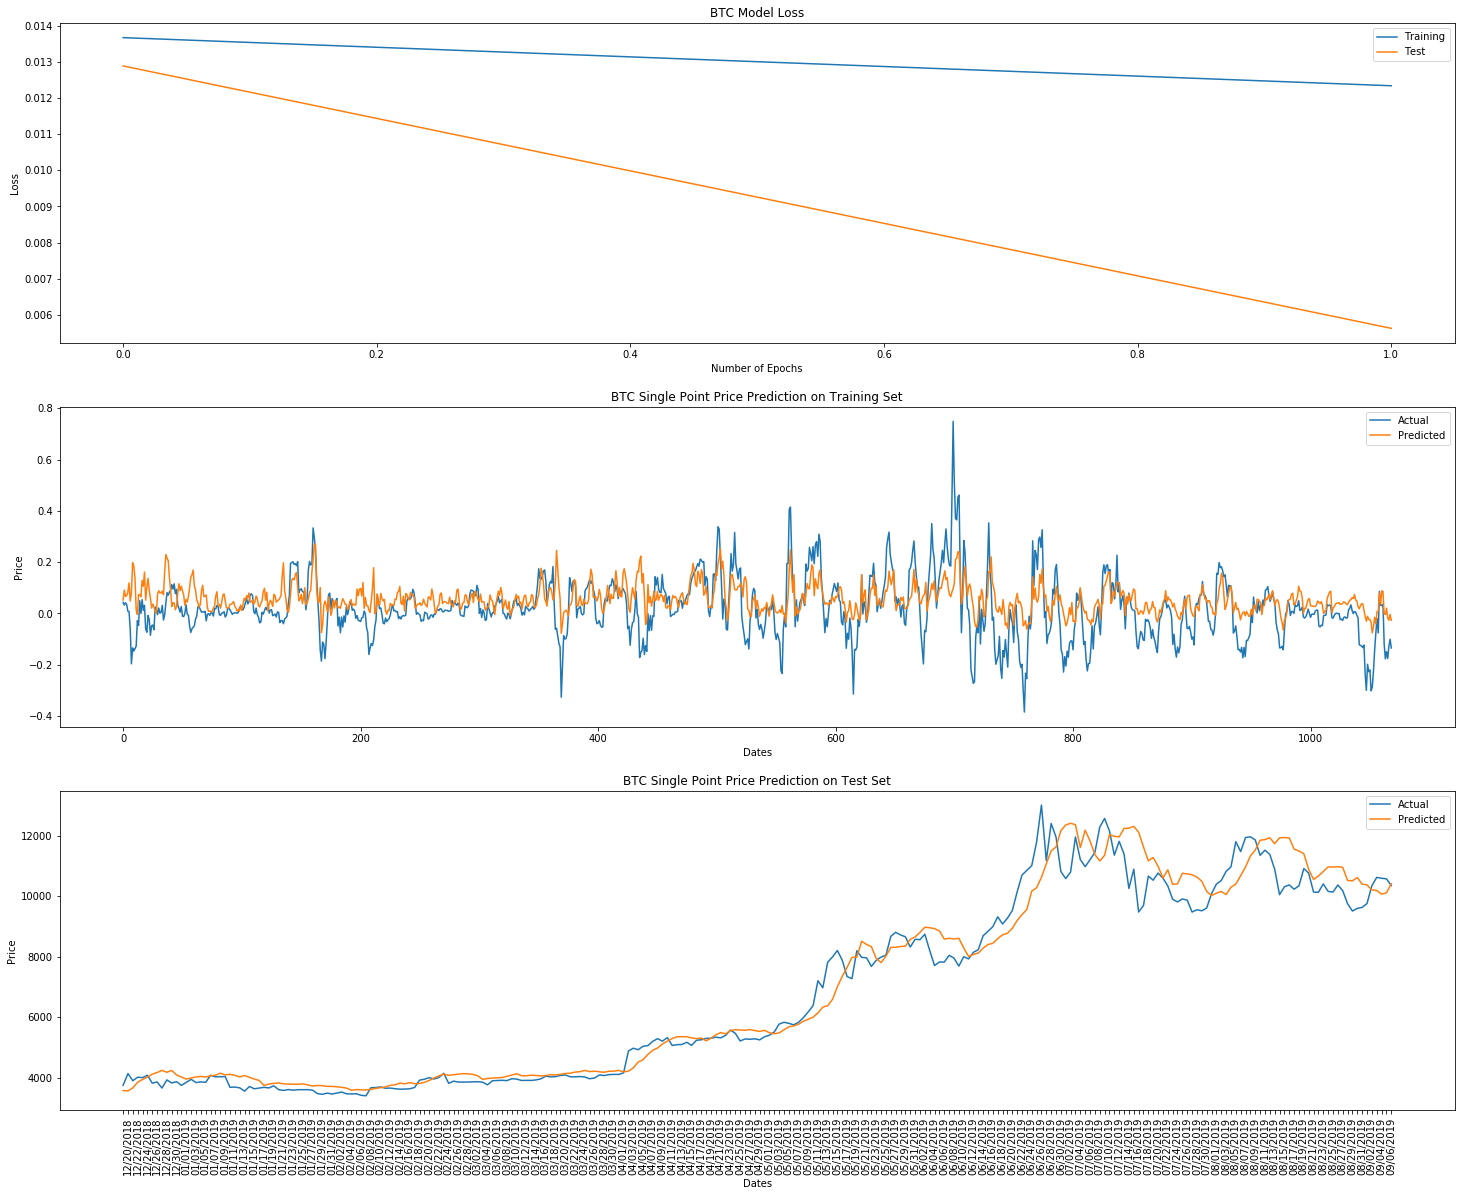

In [13]:
plot_results(btc_history, btc_model, Y_train_btc, coin='BTC')

Initializing the model and training it for predicting ETH price for next day:

In [14]:
# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

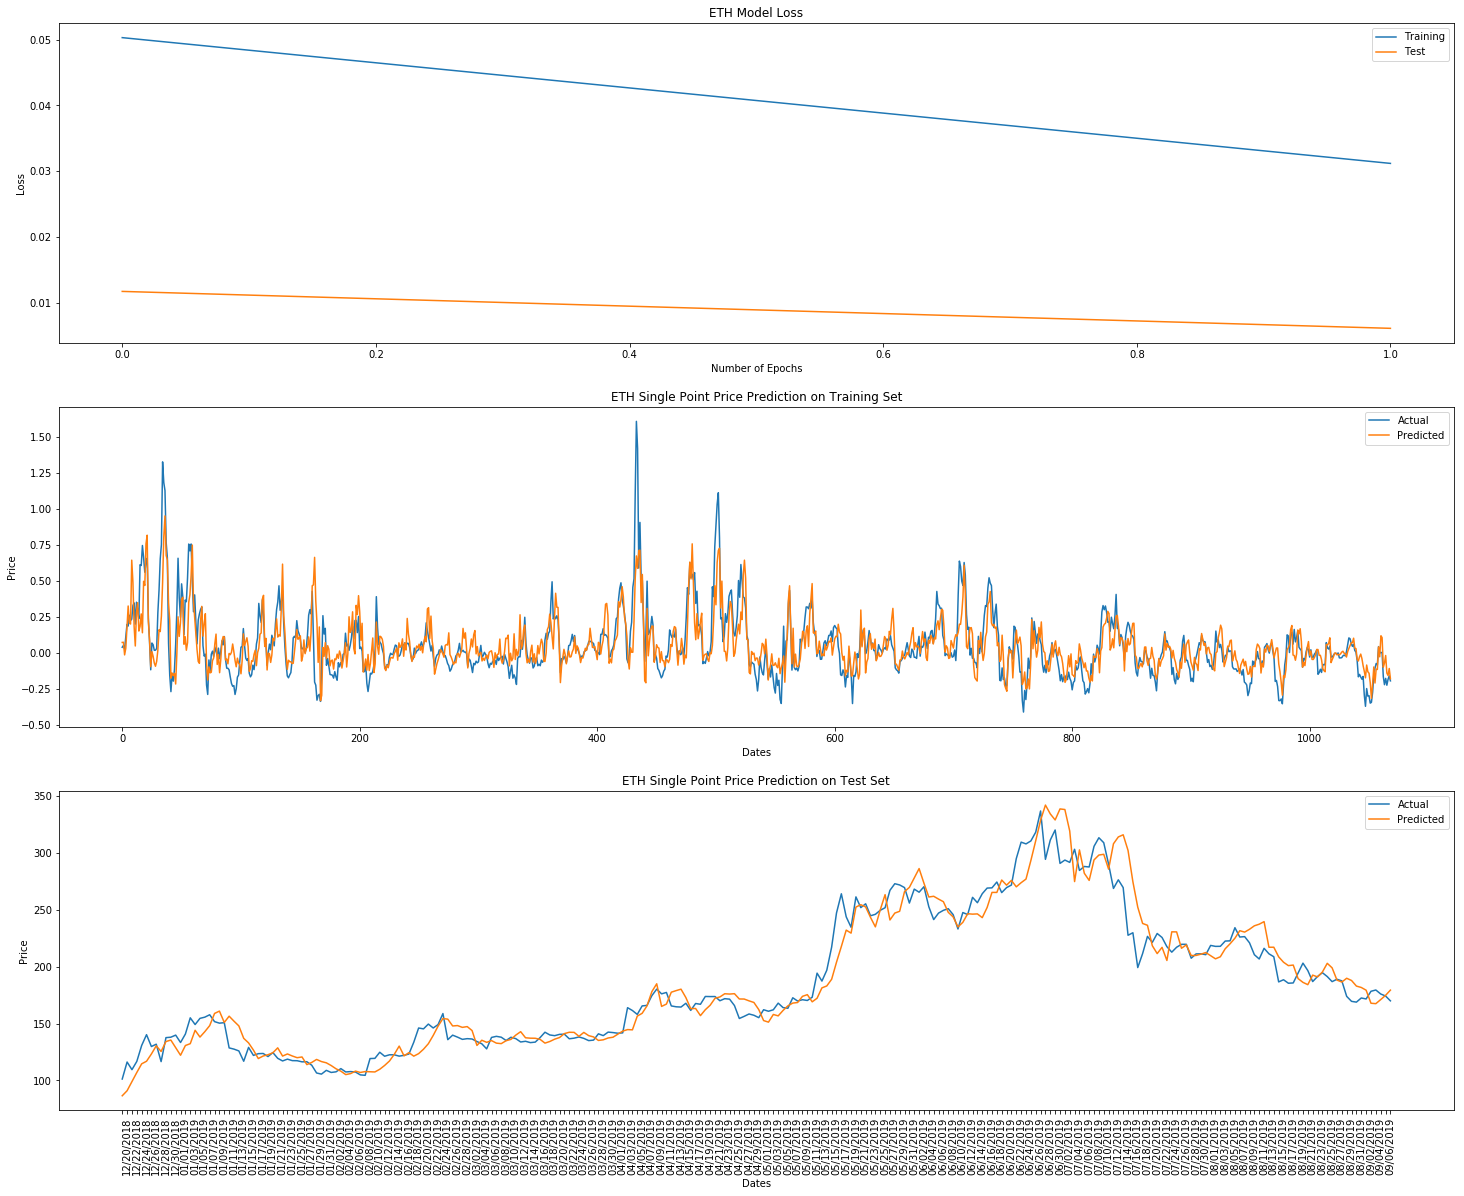

In [15]:
plot_results(eth_history, eth_model, Y_train_eth, coin='ETH')